In [1]:
import torch
from torch.utils.data import Dataset
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision import transforms
import numpy as np
from PIL import Image
from typing import Optional
import logging

In [3]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
class ImageDataset(Dataset):
    def __init__(self, image_paths: list, transform=None):
        self.image_paths = image_paths
        self.transform = transform if transform else transforms.ToTensor()
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, image_path
        except Exception as e:
            logger.error(f"Error loading image {image_path}: {e}")
            raise
        

In [3]:
class ImageFeatureExtractor:
    def __init__(self, device: Optional[str] = None):
        if device is None:
            if torch.cuda.is_available():
                self.device = "cuda"
            elif torch.backends.mps.is_available():
                self.device = "mps"
            else:
                self.device = "cpu"
        logger.info(f"Using device: {self.device}")

        self.model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        self.original_forward = self.model.forward
        self.model.forward = self._forward_features
        self.model.eval()
        self.model.to(self.device)
        self.feature_dim = 768

        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])
        
        logger.info(f"Initialized ViT feature extractor with dimension: {self.feature_dim}")

    def _forward_features(self, x):
        x = self.model._process_input(x)
        n = x.shape[0]
        cls_token = self.model.class_token.expand(n, -1, -1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.model.encoder(x)
        return x[:, 0]

    @torch.no_grad()
    def extract_features(self, image_path: str) -> np.ndarray:
        """Extract features from a single image."""
        try:
            image = Image.open(image_path).convert('RGB')
            image = self.transform(image).unsqueeze(0).to(self.device)
            
            features = self.model(image)
            
            features = features.cpu().numpy().squeeze()
            
            if features.shape != (self.feature_dim,):
                raise ValueError(f"Unexpected feature dimension: {features.shape}")
            
            norm = np.linalg.norm(features)
            if norm > 0:
                features = features / norm
            
            logger.debug(f"Extracted features shape: {features.shape}")
            logger.debug(f"Features norm: {np.linalg.norm(features)}")
            
            return features
            
        except Exception as e:
            logger.error(f"Error extracting features from {image_path}: {str(e)}")
            raise

    def __del__(self):
        # Restore original forward method when object is destroyed
        if hasattr(self, 'original_forward'):
            self.model.forward = self.original_forward

In [9]:
import requests
from PIL import Image
from io import BytesIO

model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
model.eval()
# this is the standard for vit
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d9/Collage_of_Nine_Dogs.jpg/640px-Collage_of_Nine_Dogs.jpg"
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert("RGB")

image.show()

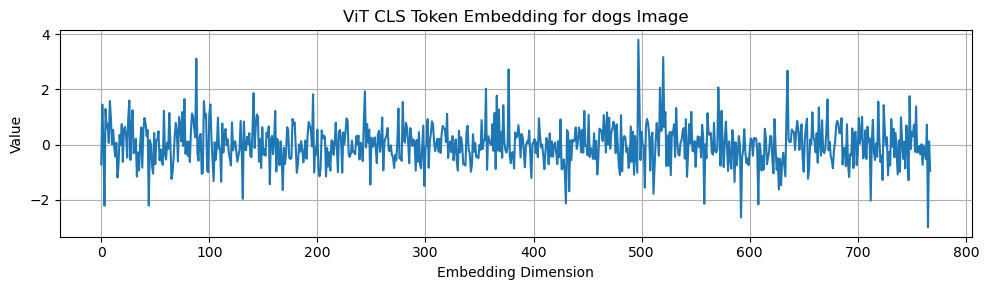

In [11]:
import matplotlib.pyplot as plt
img_tensor = transform(image).unsqueeze(0)

with torch.no_grad():
    x = model._process_input(img_tensor)
    n = x.shape[0]
    cls_token = model.class_token.expand(n, -1, -1)
    x = torch.cat((cls_token, x), dim=1)
    x = model.encoder(x)
    cls_embedding = x[:, 0]  # [1, 768]

embedding_np = cls_embedding.squeeze(0).numpy()

plt.figure(figsize=(10, 3))
plt.plot(embedding_np)
plt.title("ViT CLS Token Embedding for dogs Image")
plt.xlabel("Embedding Dimension")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

In [1]:
import os
import json
import torch
import faiss
import numpy as np
from torch.utils.data import DataLoader
from typing import List, Tuple, Optional
from datetime import datetime
import logging

- FAISS is optimized for large-scale similarity search and clustering of dense vectors.
- Clusters vector space into regions using a quantizer
- During search only a few relevant clusters are searched


# to be continued